In [11]:
from IPython import display
import requests
import json
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_columns',50)

from sklearn.preprocessing import OneHotEncoder


# Introduction

According to the Centers for Disease Control, more than 48 million Americans per year become sick from food, and an estimated 75% of the outbreaks came from food prepared by caterers, delis, and restaurants. In most cities, health inspections are generally random, which can increase time spent on spot checks at clean restaurants that have been following the rules closely — and missed opportunities to improve health and hygiene at places with more pressing food safety issues.

The goal for this project is to leverage public citizen generated data from social media to narrow the search for critical health and safety violations in New York City. As the City of New York manages  an open data portal, everyone can access historical hygiene inspections and violation records. By combine these two data source this project aims to determine which words, phrases, ratings, and patterns among restaurants lead to critical health and safety violations. This model can assist city health inspectors do their job better by prioritizing the kitchens most likely to be in violation of code.

# Obtain

This project requires data pulled from two different sources, the City of New York and Yelp. To obtain the data we will call the API keys.

## NYC Open Data API

The New York Health Department inspects the approximately 27,000 restaurants within the city to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

Calling API

In [6]:
url = 'https://data.cityofnewyork.us/resource/43nn-pn8j.json?$limit=400000'
nyc_response = requests.get(url)
nyc_response.ok
nyc_data = nyc_response.json()
nyc_data
pd.DataFrame(nyc_data)

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,grade,grade_date
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019,2129569488,Chicken,2019-01-28T00:00:00.000,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",Critical,22,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.765039752379,-73.987794608853,104,03,013300,1025235,1010430004,MN15,NaN,NaN
1,50100420,SOHO DINER,Manhattan,320,WEST BROADWAY,10013,2129653091,American,2020-01-02T00:00:00.000,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not ...,Not Critical,33,2022-03-24T06:00:41.000,Pre-permit (Operational) / Initial Inspection,40.721906385162,-74.004177657535,102,01,004700,1087764,1002270028,MN24,NaN,NaN
2,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463,7187087600,American,2019-09-23T00:00:00.000,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.886690890724,-73.90705631532,208,11,029500,2084186,2057960167,BX29,NaN,NaN
3,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022,2128882288,Asian/Asian Fusion,2020-03-11T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.762786157862,-73.971485622185,105,04,011202,1036073,1012930047,MN17,NaN,NaN
4,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022,2128882288,Asian/Asian Fusion,2020-03-11T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.762786157862,-73.971485622185,105,04,011202,1036073,1012930047,MN17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327807,41640824,RICURAS ECUADORIAN BAKERY,Bronx,1576,WATSON AVENUE,10472,7184508363,Spanish,2018-07-20T00:00:00.000,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizing solution.,Critical,12,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.826351628305,-73.876066230043,209,18,005001,2023533,2037160036,BX55,A,2018-07-20T00:00:00.000
327808,50072745,DEJA VU,Staten Island,297,PORT RICHMOND AVENUE,10302,9178567068,Mexican,2019-06-19T00:00:00.000,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment soiled with possible contaminant. Effective hair ...,Critical,36,2022-03-24T06:00:41.000,Pre-permit (Operational) / Initial Inspection,40.634311468665,-74.135861634571,501,49,021300,5024271,5010370003,SI28,NaN,NaN
327809,50057694,CHEN'S BUFFET,Manhattan,62,WILLIAM STREET,10005,2127979477,Chinese,2017-11-03T00:00:00.000,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not ...,Not Critical,13,2022-03-24T06:00:41.000,Cycle Inspection / Re-inspection,40.707158481908,-74.008793494858,101,01,000700,1001013,1000410024,MN25,A,2017-11-03T00:00:00.000
327810,41450971,GIOVANNI'S RESTAURANT,Bronx,3209,WESTCHESTER AVENUE,10461,7188924340,Pizza,2017-06-21T00:00:00.000,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rinsed and sanitized after each use and following any ...",Critical,16,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,

In [5]:
dohmh_df = pd.read_csv('https://data.cityofnewyork.us/resource/43nn-pn8j.csv?$limit=400000')

In [7]:
dohmh_df.shape

(327812, 26)

In [6]:
dohmh_df.head(3)

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2019-01-28T00:00:00.000,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",Critical,22.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.765040,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
1,50100420,SOHO DINER,Manhattan,320,WEST BROADWAY,10013.0,2129653091,American,2020-01-02T00:00:00.000,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not ...,Not Critical,33.0,NaN,NaN,2022-03-24T06:00:41.000,Pre-permit (Operational) / Initial Inspection,40.721906,-74.004178,102.0,1.0,4700.0,1087764.0,1.002270e+09,MN24
2,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.0,7187087600,American,2019-09-23T00:00:00.000,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.886691,-73.907056,208.0,11.0,29500.0,2084186.0,2.057960e+09,BX29


In [104]:
dohmh_df[dohmh_df['camis'] == 50008319]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2019-01-28T00:00:00.000,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",Critical,22.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
20933,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2019-01-28T00:00:00.000,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rinsed and sanitized after each use and following any ...",Critical,22.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
46061,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2017-08-28T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,13.0,A,2017-08-28T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
46062,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2017-08-28T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,13.0,A,2017-08-28T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
61311,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2016-12-06T00:00:00.000,Violations were cited in the following area(s).,02H,Food not cooled by an approved method whereby the internal product temperature is reduced from 1...,Critical,15.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
91814,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2017-02-02T00:00:00.000,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-...,Critical,12.0,A,2017-02-02T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Re-inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
108738,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2017-02-02T00:00:00.000,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premise...,Not Critical,12.0,A,2017-02-02T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Re-inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
138837,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2019-02-21T00:00:00.000,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Critical,7.0,A,2019-02-21T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Re-inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
153770,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2019-01-28T00:00:00.000,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or sto...",Critical,22.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.76504,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
153984,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2017-08-28T00:00:00.000

<AxesSubplot:>

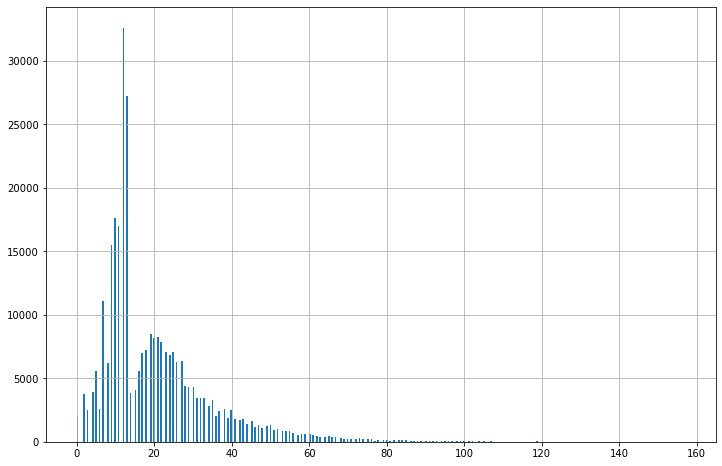

In [106]:
dohmh_df['score'].hist(bins='auto', figsize=(12,8));

In [ ]:
# # Take a look at duplicated records
# duplicates = df1.duplicated(subset=['camis'], keep=False)
# df1.loc[duplicates.loc[duplicates==True].index].sort_values(by='camis')

In [ ]:
# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.cityofnewyork.us", None)



# # Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("43nn-pn8j", limit=2000)

# # Convert to pandas DataFrame
# dohmh_df = pd.DataFrame.from_records(results)

## Yelp API

In [33]:
with open('/Users/Rob/.secret/yelp_api.json') as f:
    creds = json.load(f)

In [34]:
creds.keys()

dict_keys(['api_key'])

In [35]:
#Business Search      
url = 'https://api.yelp.com/v3/businesses/search'

#Business Match       
# url = 'https://api.yelp.com/v3/businesses/matches'

#Phone Search         
# url = 'https://api.yelp.com/v3/businesses/search/phone'

#Business Details     
# url = 'https://api.yelp.com/v3/businesses/{id}'

#Business Reviews     
# url = 'https://api.yelp.com/v3/businesses/{id}/reviews'

In [37]:
#Business Search  
headers = {
    'Authorization': 'Bearer ' + creds['api_key']
          }

SEARCH_LIMIT = 50

url_params = {
    'limit': SEARCH_LIMIT,
    'location' : 'New York City',
    'offset': 0
             }


response = requests.get(url, headers=headers, params=url_params)
print(response.status_code)

200


In [46]:
# Functionize the Yelp API call
def get_results(location, SEARCH_LIMIT=50,
                url='https://api.yelp.com/v3/businesses/search',
                cred=None,fpath='/Users/Rob/.secret/yelp_api.json',
                offset=820):
    
    
    if cred is None:
    
        with open(fpath) as f:
            cred = json.load(f)

    headers = {
        'Authorization': 'Bearer ' + cred['api_key']
    }

    url_params = {
        'limit': SEARCH_LIMIT,
        'location' : location,
        'offset': offset
    }


    response = requests.get(url, headers=headers, params=url_params)
    return response.json()

In [39]:
response = get_results('NYC')

In [40]:
n_per_page = len(response['businesses'])

In [41]:
response2 = get_results('NYC',offset=n_per_page)
pd.DataFrame(response2['businesses']).head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,xt4sa64WOrpJvZBDPNPNYg,jacobs-pickles-new-york,Jacob's Pickles,https://s3-media1.fl.yelpcdn.com/bphoto/yU9q4U1WSk6diDF0dcA9ag/o.jpg,False,https://www.yelp.com/biz/jacobs-pickles-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_camp...,4739,"[{'alias': 'comfortfood', 'title': 'Comfort Food'}, {'alias': 'southern', 'title': 'Southern'}, ...",4.0,"{'latitude': 40.7866504411994, 'longitude': -73.9755284786224}","[delivery, pickup]",$$,"{'address1': '509 Amsterdam Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code'...",+12124705566,(212) 470-5566,9166.964738
1,ga6sRtE0l85iftw_5-W84Q,dominique-ansel-bakery-new-york,Dominique Ansel Bakery,https://s3-media3.fl.yelpcdn.com/bphoto/ae6sDhEfUXTE5EKfWSOrCQ/o.jpg,False,https://www.yelp.com/biz/dominique-ansel-bakery-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&...,4953,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {'alias': 'desserts', 'title': 'Desserts'}]",4.0,"{'latitude': 40.72516, 'longitude': -74.00296}",[delivery],$$,"{'address1': '189 Spring St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '1...",+12122192773,(212) 219-2773,2312.769277
2,vk7W3_sQwr7eZbRFsXv6rw,taiyaki-nyc-new-york,Taiyaki NYC,https://s3-media4.fl.yelpcdn.com/bphoto/F3Vyd-otu36oE8B8M1XXug/o.jpg,False,https://www.yelp.com/biz/taiyaki-nyc-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaig...,3091,"[{'alias': 'desserts', 'title': 'Desserts'}, {'alias': 'japanese', 'title': 'Japanese'}, {'alias...",4.5,"{'latitude': 40.71789, 'longitude': -73.9988}","[delivery, pickup]",$,"{'address1': '119 Baxter St', 'address2': '', 'address3': None, 'city': 'New York', 'zip_code': ...",+12129662882,(212) 966-2882,1439.725809
3,FEVQpbOPOwAPNIgO7D3xxw,shake-shack-new-york-2,Shake Shack,https://s3-media1.fl.yelpcdn.com/bphoto/T-tX3g_OErxUpBtZDo1ixg/o.jpg,False,https://www.yelp.com/biz/shake-shack-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campa...,5655,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'foodstands', 'title': 'Food Stands'}, {'al...",4.0,"{'latitude': 40.74212, 'longitude': -73.98707}","[delivery, pickup]",$$,"{'address1': 'E 23rd St Madison Ave', 'address2': '', 'address3': 'Madison Square Park', 'city':...",+12128896600,(212) 889-6600,3975.513089
4,ysqgdbSrezXgVwER2kQWKA,julianas-brooklyn-3,Juliana's,https://s3-media2.fl.yelpcdn.com/bphoto/clscwgOF9_Ecq-Rwsq7jyQ/o.jpg,False,https://www.yelp.com/biz/julianas-brooklyn-3?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign...,2408,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.70274718768062, 'longitude': -73.99343490196397}",[delivery],$$,"{'address1': '19 Old Fulton St', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code':...",+17185966700,(718) 596-6700,308.569844


### Loop Through Pagination

In [47]:
offset=820
response = get_results('NYC',offset=offset)
n_per_page = len(response['businesses'])
total_result = response['total']

results = response['businesses']

while offset < total_result:
    offset+=n_per_page
    res = get_results('NYC',offset=offset)
    results.extend(res['businesses'])
results[:5]

KeyError: 'businesses'

In [48]:
len(results)

820

In [9]:
# df = pd.DataFrame(results)
# df.to_csv('yelp_results.csv',index=False)
df = pd.read_csv('yelp_results.csv')
df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,H4jJ7XB3CetIr1pg56CczQ,levain-bakery-new-york,Levain Bakery,https://s3-media3.fl.yelpcdn.com/bphoto/hCp7TJqo1m_rGPkvso4dxw/o.jpg,False,https://www.yelp.com/biz/levain-bakery-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campa...,8751,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",4.5,"{'latitude': 40.779961, 'longitude': -73.980299}",[],$$,"{'address1': '167 W 74th St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '1...",1.917464e+10,(917) 464-3769,8369.262425
1,V7lXZKBDzScDeGB8JmnzSA,katzs-delicatessen-new-york,Katz's Delicatessen,https://s3-media4.fl.yelpcdn.com/bphoto/7Yn37rOW4VQDI396jPPoyA/o.jpg,False,https://www.yelp.com/biz/katzs-delicatessen-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_...,13391,"[{'alias': 'delis', 'title': 'Delis'}, {'alias': 'sandwiches', 'title': 'Sandwiches'}, {'alias':...",4.0,"{'latitude': 40.722237, 'longitude': -73.9875259}","['delivery', 'pickup']",$$,"{'address1': '205 E Houston St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code':...",1.212254e+10,(212) 254-2246,1952.370624
2,44SY464xDHbvOcjDzRbKkQ,ippudo-ny-new-york-7,Ippudo NY,https://s3-media1.fl.yelpcdn.com/bphoto/zF3EgqHCk7zBUwD2B3WTEA/o.jpg,False,https://www.yelp.com/biz/ippudo-ny-new-york-7?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaig...,10202,"[{'alias': 'ramen', 'title': 'Ramen'}]",4.0,"{'latitude': 40.73092, 'longitude': -73.99015}","['delivery', 'pickup']",$$,"{'address1': '65 4th Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '1000...",1.212388e+10,(212) 388-0088,2854.301267
3,xEnNFXtMLDF5kZDxfaCJgA,the-halal-guys-new-york-2,The Halal Guys,https://s3-media2.fl.yelpcdn.com/bphoto/pqcdqGpzyurT2pSVA9G2kw/o.jpg,False,https://www.yelp.com/biz/the-halal-guys-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,9791,"[{'alias': 'foodstands', 'title': 'Food Stands'}, {'alias': 'mideastern', 'title': 'Middle Easte...",4.0,"{'latitude': 40.761861, 'longitude': -73.979306}","['delivery', 'pickup']",$,"{'address1': 'W 53rd Street And 6th Ave', 'address2': None, 'address3': '', 'city': 'New York', ...",1.347527e+10,(347) 527-1505,6399.019110
4,KFnr0CGsHQ2ABFHbLNtobQ,central-park-conservancy-new-york,Central Park Conservancy,https://s3-media2.fl.yelpcdn.com/bphoto/2QeE4ZRjzmUsNDnqXCGqfA/o.jpg,False,https://www.yelp.com/biz/central-park-conservancy-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1...,2614,"[{'alias': 'parks', 'title': 'Parks'}]",5.0,"{'latitude': 40.764266, 'longitude': -73.971656}",[],NaN,"{'address1': '14 E 60th St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10...",1.212311e+10,(212) 310-6600,6814.558070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,qXuUBEaib4caLC6WCPhBjA,patisserie-tomoko-brooklyn-2,Patisserie Tomoko,https://s3-media4.fl.yelpcdn.com/bphoto/vsCTCMcpWEnrAs7DvTtcZg/o.jpg,False,https://www.yelp.com/biz/patisserie-tomoko-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm...,367,"[{'alias': 'desserts', 'title': 'Desserts'}, {'alias': 'bakeries', 'title': 'Bakeries'}, {'alias...",4.5,"{'latitude': 40.7176114, 'longitude': -73.9519192}","['delivery', 'pickup']",$$,"{'address1': '568 Union Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '1...",1.718389e+10,(718) 388-7121,3819.173953
816,McU7XI3HoWFELTDaGc1SEw,ginger-and-lemongrass-new-york-2,Ginger and Lemongrass,https://s3-media2.fl.yelpcdn.com/bphoto/hsU_1M52BlXu1X5t9a4-ZQ/o.jpg,False,https://www.yelp.com/biz/ginger-and-lemongrass-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A...,480,"[{'alias': 'vietnamese', 'title': 'Vietnamese'}, {'alias': 'thai', 'title': 'Thai'}, {'alias': '...",4.0,"{'latitude': 40.71912, 'longitude': -73.98567}","['delivery', 'pickup']",$$,"{'address1': '153 Rivington St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code...",1.646876e

In [ ]:
# response.json().keys()

In [ ]:
# yelp_df = pd.DataFrame(response.json()['businesses'])
# # yelp_df.head(3)

In [ ]:
# lat = []
# long = []

# for _,business in yelp_df.iterrows():
#     lat.append(business['coordinates']['latitude'])
#     long.append(business['coordinates']['longitude'])

# yelp_df['lat'] = lat
# yelp_df['long'] = long

# Data Understanding

For this project there will be two sources and types of data used:

* Historical health and hygiene inspections recorded by New York City Department of Health and Mental Hygiene (DOHMH) public health inspectors
* User generated Yelp business ratings and reviews

## Understanding NYC DOHMH Data

This dataset contains over 330,000 records, let's explore its contents.

In [25]:
dohmh_df['inspection_date'] =  pd.to_datetime(dohmh_inspections['inspection_date'])

In [26]:
dohmh_df['inspection_date'].min()

Timestamp('2009-05-16 14:26:00')

In [27]:
dohmh_df['inspection_date'].max()

Timestamp('2022-03-23 00:00:00')

Inspections in this dataset range from May 2008 up to present day.

In [30]:
# dohmh_df.set_index('inspection_date')

In [8]:
dohmh_df['boro'].value_counts()

Manhattan        128531
Brooklyn          80711
Queens            76067
Bronx             32081
Staten Island     10328
0                    94
Name: boro, dtype: int64

In [9]:
dohmh_df['score'].value_counts()

12.0     32619
13.0     27258
10.0     17650
11.0     17018
9.0      15522
         ...  
150.0        9
109.0        8
132.0        8
136.0        7
112.0        5
Name: score, Length: 130, dtype: int64

Health code violations found during an inspections carries a point value, and a restaurant’s score corresponds to a letter grade. A lower point score, leads to a better letter grade:

"A" grade: 0 to 13 points for sanitary violations
"B" grade: 14 to 27 points for sanitary violations
"C" grade: 28 or more points for sanitary violations

In [10]:
dohmh_df['score'].isna().sum()

15183

In [11]:
dohmh_df['grade'].value_counts()

A    129112
B     18953
C      7804
N      4394
Z      3447
P      1929
G         1
Name: grade, dtype: int64

In [107]:
dohmh_df['grade'].value_counts(normalize=True)

A    0.779474
B    0.114423
C    0.047114
N    0.026527
Z    0.020810
P    0.011646
G    0.000006
Name: grade, dtype: float64

In [12]:
dohmh_df['grade'].isna().sum()

162172

In [13]:
dohmh_df['critical_flag'].value_counts()

Critical          172065
Not Critical      150074
Not Applicable      5673
Name: critical_flag, dtype: int64

Critical violations are those most likely to contribute to foodborne illness

In [14]:
dohmh_df['critical_flag'].value_counts(normalize=True)

Critical          0.524889
Not Critical      0.457805
Not Applicable    0.017306
Name: critical_flag, dtype: float64

In [15]:
dohmh_df['inspection_type'].value_counts()

Cycle Inspection / Initial Inspection                          186227
Cycle Inspection / Re-inspection                                71636
Pre-permit (Operational) / Initial Inspection                   31948
Pre-permit (Operational) / Re-inspection                        12584
Administrative Miscellaneous / Initial Inspection                5855
Cycle Inspection / Reopening Inspection                          3128
Pre-permit (Non-operational) / Initial Inspection                2987
Smoke-Free Air Act / Initial Inspection                          1440
Administrative Miscellaneous / Re-inspection                     1404
Pre-permit (Operational) / Compliance Inspection                 1193
Pre-permit (Operational) / Reopening Inspection                  1089
Trans Fat / Initial Inspection                                   1038
Inter-Agency Task Force / Initial Inspection                      974
Calorie Posting / Initial Inspection                              643
Cycle Inspection / C

In [12]:
dohmh_inspections = dohmh_df[(dohmh_df['inspection_type'] ==
                              'Cycle Inspection / Initial Inspection') | (dohmh_df['inspection_type'] ==
                              'Cycle Inspection / Re-inspection')]

In [13]:
dohmh_inspections['critical_flag'].value_counts()

Critical          142171
Not Critical      115284
Not Applicable       408
Name: critical_flag, dtype: int64

In [14]:
# Drop records with NA critical_flag

dohmh_ohe = dohmh_inspections[dohmh_inspections['critical_flag'] != 'Not Applicable']

In [17]:
dohmh_ohe = pd.get_dummies(dohmh_inspections,columns=['critical_flag'])

In [18]:
dohmh_ohe.head(2)

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,critical_flag_Critical,critical_flag_Not Applicable,critical_flag_Not Critical
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,2019-01-28T00:00:00.000,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",22.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.765040,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15,1,0,0
2,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.0,7187087600,American,2019-09-23T00:00:00.000,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,24.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.886691,-73.907056,208.0,11.0,29500.0,2084186.0,2.057960e+09,BX29,1,0,0


In [99]:
critical_flags = dohmh_ohe.groupby(['camis'])['critical_flag_Critical'].count()

In [98]:
critical_flags[critical_flagss]

,dba,critical_flag_Critical
camis,,
30075445,12,12
30112340,9,9
30191841,5,5
40356018,4,4
40356483,12,12
...,...,...
50115169,1,1
50116155,3,3
50117350,5,5


In [54]:
critical_flags['critical_flag_Not Critical'].sum()

115284

In [41]:
non_critical_flags = dohmh_ohe.groupby(['camis'])

In [43]:
dohmh_inspections.duplicated().sum()

15701

In [19]:
dohmh_inspections.loc[dohmh_inspections.duplicated(keep='first'),:]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
4,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.0,2128882288,Asian/Asian Fusion,2020-03-11T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.762786,-73.971486,105.0,4.0,11202.0,1036073.0,1.012930e+09,MN17
91,41489806,MASALA TIMES,Manhattan,194,BLEECKER STREET,10012.0,2129955100,Indian,2019-02-05T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,32.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.729306,-74.001512,102.0,3.0,6500.0,1008300.0,1.005260e+09,MN23
95,50084938,TACO BELL CANTINA,Manhattan,500,8 AVENUE,10018.0,9292323040,Tex-Mex,2020-01-02T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,13.0,A,2020-01-02T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.752936,-73.992904,105.0,3.0,10900.0,1014421.0,1.007850e+09,MN17
97,41129343,PINO'S LA FORCHETTA,Brooklyn,181,7 AVENUE,11215.0,7189654020,Pizza,2019-12-07T00:00:00.000,Violations were cited in the following area(s).,06C,"Food not protected from potential source of contamination during storage, preparation, transport...",Critical,18.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.671373,-73.977826,306.0,39.0,15500.0,3025166.0,3.010760e+09,BK37
132,50049662,NEW CARRIZAL RESTAURANT,Brooklyn,1346,BROADWAY,11221.0,3479150505,Spanish,2017-10-05T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,25.0,B,2017-10-05T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Re-inspection,40.689846,-73.922704,303.0,41.0,37500.0,3039620.0,3.014790e+09,BK35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327759,50043744,CARIBBEAN COFFEE SHOP,Brooklyn,527,STANLEY AVENUE,11207.0,7189752301,Caribbean,2018-04-04T00:00:00.000,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near food preparation area and toilet room. Hot and col...,Critical,43.0,NaN,NaN,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.657221,-73.888863,305.0,42.0,110400.0,3097671.0,3.043470e+09,BK82
327796,50003774,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,Brooklyn,4108,FARRAGUT ROAD,11210.0,7185766021,Caribbean,2019-09-09T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,4.0,A,2019-09-09T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Re-inspection,40.636919,-73.937311,317.0,45.0,83600.0,3114504.0,3.050160e+09,BK91
327797,50003774,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,Brooklyn,4108,FARRAGUT ROAD,11210.0,7185766021,Caribbean,2019-09-09T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,4.0,A,2019-09-09T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Re-inspection,40.636919,-73.937311,317.0,45.0,83600.0,3114504.0,3.050160e+09,BK91
327799,41556790,FIVE GUYS FAMOUS BURGERS AND FRIES,Manhattan,2847,BROADFWAY,NaN,2126787701,Hamburgers,2019-03-01T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food 

In [44]:
dohmh_inspections.drop_duplicates().shape

(242162, 26)

In [45]:
dohmh_inspections.duplicated(subset=['camis']).sum()

238071

In [46]:
dohmh_inspections['camis'].nunique()

19792

There are approximately 28,000 restaurants that have been inspected by the DOHMH. Let's check out how many have ever been flagged for a critical violation.

In [51]:
dohmh_ohe[dohmh_ohe['camis'] == 50084938]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,critical_flag_Critical,critical_flag_Not Applicable,critical_flag_Not Critical
94,50084938,TACO BELL CANTINA,Manhattan,500,8 AVENUE,10018.0,9292323040,Tex-Mex,2020-01-02T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,13.0,A,2020-01-02T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.752936,-73.992904,105.0,3.0,10900.0,1014421.0,1.007850e+09,MN17,0,0,1
95,50084938,TACO BELL CANTINA,Manhattan,500,8 AVENUE,10018.0,9292323040,Tex-Mex,2020-01-02T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,13.0,A,2020-01-02T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.752936,-73.992904,105.0,3.0,10900.0,1014421.0,1.007850e+09,MN17,0,0,1
43749,50084938,TACO BELL CANTINA,Manhattan,500,8 AVENUE,10018.0,9292323040,Tex-Mex,2020-01-02T00:00:00.000,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rinsed and sanitized after each use and following any ...",13.0,A,2020-01-02T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.752936,-73.992904,105.0,3.0,10900.0,1014421.0,1.007850e+09,MN17,1,0,0
231801,50084938,TACO BELL CANTINA,Manhattan,500,8 AVENUE,10018.0,9292323040,Tex-Mex,2020-01-02T00:00:00.000,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or sto...",13.0,A,2020-01-02T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.752936,-73.992904,105.0,3.0,10900.0,1014421.0,1.007850e+09,MN17,1,0,0
306401,50084938,TACO BELL CANTINA,Manhattan,500,8 AVENUE,10018.0,9292323040,Tex-Mex,2021-08-03T00:00:00.000,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,3.0,A,2021-08-03T00:00:00.000,2022-03-24T06:00:41.000,Cycle Inspection / Initial Inspection,40.752936,-73.992904,105.0,3.0,10900.0,1014421.0,1.007850e+09,MN17,0,0,1


## Mapping with Follium